### Data Import

Import the data from the data directory containing METRo forecasts and monitor data from 29th of October 2018 till the 14th of March 2019.

In [1]:
import pandas as pd
import numpy as np

def loader():
    """Reading data from keys"""
    with open("data/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("data/data_{}.csv".format(str(key)))

    return dictex

df = loader()

### Define the feature space

Here the features are defined that are used for the METRo forecasts

In [18]:
# from horizon_handler
HORIZON_FEATURES = ['radiation', 'shade']

# from SMHI
FCST_FEATURES = ['AirTemp', 'DewPoint', 'RainPrecip', 'SnowPrecip', 'SnowPrecipAccumulated', 'WindSpeed',
                 'AirPressure', 'OctalCloudCoverage', 'PrecipAmount']
# from METRo
EBM_FEATURES = ['air_temp', 'dew_point', 'surf_temp', 'water_amount', 'snow_amount', 'sub_temp']


# setting the independent and dependent features
INDEPENDENT_FEATURES = HORIZON_FEATURES + FCST_FEATURES + EBM_FEATURES

### Hyperparameter Extraction

Here the functions are defined for extracting the hyperparameters of the neural networks using a randomized search.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

def get_best_value_of_k(samples, targets, ran):
    best_k_value = 0
    best_score = 100
    for i in range(1, ran):
        model = KNeighborsRegressor(n_neighbors=i+1, 
                                algorithm='auto')
        scores = cross_val_score(model, samples, targets, cv=2)
        if (np.mean(scores)**2 < best_score):
            best_score = np.mean(scores)**2
            best_k_value = i+1
    return best_k_value, best_score

### Retrieving the hyperparameters

Here the best hyperparameters are extracted for each model. This takes a while to test, but the from running this experiment yielded:

In [143]:
dfTest = loader()
k_values = dict()

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in dfTest.keys():
    if allowed_key(key):
        X_train, X_test, y_train, y_test = getValues(dfTest[key], raw=True)
        X_train, X_test = normalize(X_train, X_test)
        
        best_k_value, best_score = get_best_value_of_k(X_train, y_train, 10)
        k_values[key] = best_k_value
        print(key, best_k_value, best_score)
        

(1419, 1) 2 0.0011899662510712664
(1419, 5) 5 0.03188163067994646
(1419, 9) 10 0.13431944622691339
(1419, 18) 10 0.13391878173297633
(1433, 1) 3 0.011926150112634891
(1433, 5) 10 0.02024830916683474
(1433, 9) 10 0.03264657070837812
(1433, 18) 10 0.0842349469810978
(1440, 1) 10 0.009110952493917503
(1440, 5) 10 0.018086262447473037
(1440, 9) 10 0.06480199825664981
(1440, 18) 10 0.1758363936707969
(1417, 1) 10 0.00024804508545779147
(1417, 5) 2 0.0433746722840234
(1417, 9) 10 0.10817445093200047
(1417, 18) 10 0.1022078268017507


### Model Functions

These functions are used for normalizing the dataset as well as building and fitting the models

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
import sys
import pickle

def fit_knn(samples, targets, k):
    model = KNeighborsRegressor(n_neighbors=k, 
                                algorithm='auto', 
                                weights='distance')
    model.fit(samples, targets)
    # print_feature_importance(samples, targets)
    return model

def forecast_knn(model, samples):
    predictions = model.predict(samples)
    return predictions

def normalize(train, test):
    mean = train.mean(axis=0)    
    train -= mean
    std = train.std(axis=0)
    train /= std

    test -= mean
    test /= std
    return train, test

def getValues(data, raw=False):
    data.set_index("Date Time", inplace=True)
    included = np.array(data[INDEPENDENT_FEATURES + ['surf_temp_sqerror']].notnull().all(axis=1))

    rsi = {
        "data": data.loc[included, INDEPENDENT_FEATURES].values.astype(np.float), 
        "target": data.loc[included, 'surf_temp_sqerror'].values.astype(np.float)
    }
    
    if (raw):
        return train_test_split(rsi["data"], rsi["target"], test_size=0.0, random_state=0)
    return train_test_split(rsi["data"], rsi["target"], test_size=0.3, random_state=0)


### Extracting and printing the feature importances in negative MSE

In [ ]:
def print_feature_importance(samples, targets):
    print('Feature  Accuracy')
    for i in range(samples.shape[1]):
        X = samples[:, i].reshape(-1, 1)
        scores = cross_val_score(KNeighborsRegressor(), X, targets, scoring='neg_mean_squared_error')
        print(scores.mean())

### Plot predictions
Used for plotting a graph depicting the true and estimated target value for approximations about model accuracy and overfitting/underfitting analysis.

In [144]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

def plotPredictions(key, true, predictions):
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    pyplot.scatter(true, predictions, color="red", alpha=0.5, s=10)
    pyplot.xlim(0,20)
    pyplot.ylim(0,20)
    pyplot.plot(range(60), color='black', alpha=0.2)
    pyplot.grid()
    pyplot.title(key, fontsize=16)
    pyplot.xlabel('surf_temp_sqerror')
    pyplot.ylabel('Estimated surf_temp_sqerror')

### Experiment 1
The first experiment tested on the dataset collected from the winter season

In [145]:
def experiment(k_value, data, key):
    X_train, X_test, y_train, y_test = getValues(data)
    X_train, X_test = normalize(X_train, X_test)

    error_scores = list()
    print(key)
    knn_model = fit_knn(X_train, y_train, k_value)
    
    with open('models/knn/model_{}'.format(key), 'wb') as f:
        pickle.dump(knn_model, f)

    predictions = forecast_knn(knn_model, X_test)
    true = y_test

    # report performance
    mse = mean_squared_error(true, predictions)
    print('Test MSE: %.3f' % (mse))
    error_scores.append(mse)
    plotPredictions(key, true, predictions)
    
    return true, predictions, error_scores, knn_model

### Running the experiment
The experiment is run for the selected forecast lengths (1, 5, 9 and 18) which is extracted from the dataset. After the iterations,

In [146]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

df = loader()

trueVals = []
predictedVals = []
results = dict()
models = dict()

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        true, predictions, error_scores, knn_model = experiment(k_values[key], df[key], key)
        results[key] = error_scores
        models[key] = knn_model
        trueVals.extend(true)
        predictedVals.extend(predictions)
    

(1419, 1)
Test MSE: 0.488
(1419, 5)
Test MSE: 11.655
(1419, 9)
Test MSE: 10.347
(1419, 18)
Test MSE: 11.525
(1433, 1)
Test MSE: 0.283
(1433, 5)
Test MSE: 3.836
(1433, 9)
Test MSE: 5.712
(1433, 18)
Test MSE: 8.826
(1440, 1)
Test MSE: 0.142
(1440, 5)
Test MSE: 1.622
(1440, 9)
Test MSE: 2.530
(1440, 18)
Test MSE: 4.103
(1417, 1)
Test MSE: 0.795
(1417, 5)
Test MSE: 7.377
(1417, 9)
Test MSE: 10.151
(1417, 18)
Test MSE: 9.641


### Saving and loading the results
The results from the first experiment is saved to the results directory. Another method is defined to retrieve the stored results.

In [168]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("results/knn/results_{}.csv".format(str(key)))

    with open("results/knn/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))
        
saver(results)

In [ ]:
def result_loader():
    """Reading data from keys"""
    with open("results/knn/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("results/knn/results_{}.csv".format(str(key)))

    return dictex

### Depicting the Error Span of the Predictions
To better showcase the model estimations, an errorbar plot are created to depict the error span of the predictions contra the true value.

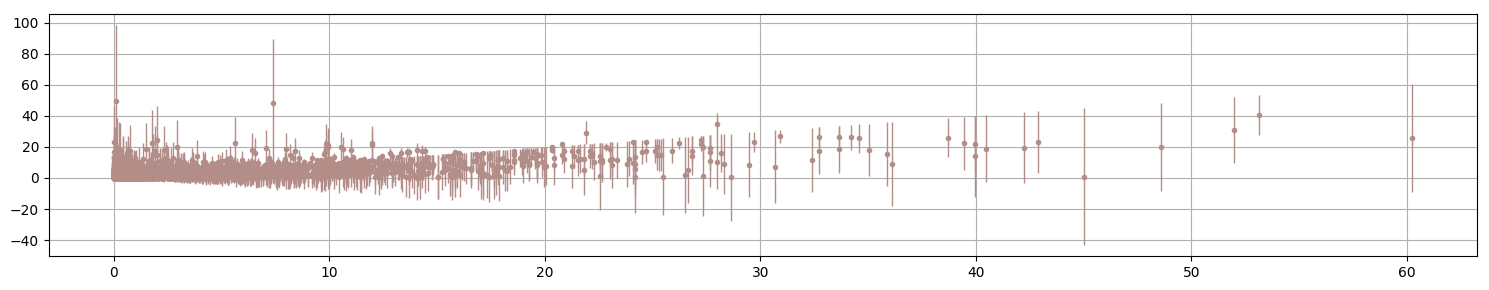

In [196]:
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt
#plt.rcdefaults()

# First illustrate basic pyplot interface, using defaults where possible.
plt.errorbar(trueVals, predictedVals, yerr=diffVals, fmt='.', elinewidth=1, color='#B38E89')
plt.grid(True)
plt.tight_layout()
plt.rcParams["figure.figsize"] = (15,3)

plt.savefig('error_selection_knn.png')
plt.show()

### MSE result depiction
The following graphs depicts a boxplot for the results of the dense neural network models

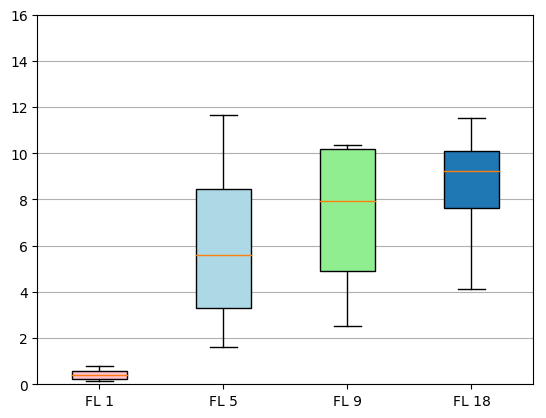

In [230]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()

def result_loader():
    """Reading data from keys"""
    with open("results/knn/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("results/knn/results_{}.csv".format(str(key)))

    return dictex

results = result_loader()

all_data = dict()
# Random test data
for key in [1417, 1419, 1433, 1440]:
    for fl in [1, 5, 9, 18]:
        if fl not in all_data.keys():
            all_data[fl] = []
        all_data[fl].append(results[(key, fl)].values[0][1])
    labels = ['FL 1', 'FL 5', 'FL 9', 'FL 18']

all_data = list(all_data.values())
fig, axes = plt.subplots()

# rectangular box plot
bplot1 = axes.boxplot(all_data, 0, '',
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_ylim([0, 16])

plt.savefig('mse_box_plot_knn.png'.format(str(key)))
plt.show()

### Loading the second dataset
Import the data from the data directory containing METRo forecasts and monitor data from 14th of March 2018 till the 5th of May 2019.

In [ ]:
def loader2():
    """Reading data from keys"""
    with open("data2/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("data2/data_{}.csv".format(str(key)))

    return dictex

### Experiment 2
The second experiment involves training the models on newer data collected from the spring season, that is, the models are reused and continously trained.

Below is the methods used for processing the dataset, which needed a different normalizing setting because some standard deviation outcomes were zero, which makes the scaled value zero for that feature (https://stackoverflow.com/a/54623752/7296909).

In [59]:
import pandas as pd
import numpy as np

def normalize(train, test):
    mean = train.mean(axis=0)    
    train -= mean
    std = train.std(axis=0)
    for i in range(len(std)):
        if (std[i] == 0.0):
            std[i] = 1.0
    train /= std

    test -= mean
    test /= std
    return train, test

### Experiment Method
Implementation for the second experiment loading saved models and testing them with the new dataset.

In [127]:
def experiment2(model, data, key):
    X_train, X_test, y_train, y_test = getValues(data)
    X_train, X_test = normalize(X_train, X_test)

    error_scores = list()
    print(key)
    with open('models/knn/model_{}'.format(key), 'rb') as f:
        knn_model = pickle.load(f)

    predictions = forecast_knn(knn_model, X_test)
    true = y_test

    # report performance
    mse = mean_squared_error(true, predictions)
    print('Test MSE: %.3f' % (mse))
    error_scores.append(mse)
    plotPredictions(key, true, predictions)
    
    return true, predictions, error_scores

### Running the experiment
The experiment is run for the selected forecast lengths (1, 5, 9 and 18) which is extracted from the dataset. After the iterations,

In [128]:
%matplotlib inline

df = loader()

import warnings
warnings.filterwarnings('ignore')

trueVals = []
predictedVals = []
results = dict()

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        true, predictions, error_scores = experiment2(models[key], df[key], key)
        results[key] = error_scores
        trueVals.extend(true)
        predictedVals.extend(predictions)

### Saving the results from the second experiment
The results from the second experiment is saved to the results2 directory.

In [64]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("results2/knn/results_{}.csv".format(str(key)))

    with open("results2/knn/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))
        
saver(results)